# IMPORTS

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

## LEITURA DOS DADOS

In [84]:
df = pd.read_csv('../RawData/train_radiomics_hipocamp.csv') 
df_test = pd.read_csv('../RawData/test_radiomics_hipocamp.csv')

# Tratamento

### Single Value Colums 

In [85]:
df = df.loc[:, df.nunique() > 1]
df_test = df_test.loc[:, df_test.nunique() > 1]


#  Analise das colunas que tem menos de 50 valores unicos 
n = df.nunique()
for col, e in n.items():
    if e < 50:  
        print(f"Coluna: {col}, Valores Unicos : {e}")

Coluna: original_firstorder_10Percentile, Valores Unicos : 31
Coluna: original_firstorder_90Percentile, Valores Unicos : 13
Coluna: original_firstorder_InterquartileRange, Valores Unicos : 13
Coluna: original_firstorder_Maximum, Valores Unicos : 29
Coluna: original_firstorder_Median, Valores Unicos : 15
Coluna: original_firstorder_Minimum, Valores Unicos : 30
Coluna: original_firstorder_Range, Valores Unicos : 45
Coluna: wavelet-HHH_glszm_GrayLevelNonUniformityNormalized, Valores Unicos : 33
Coluna: wavelet-HHH_glszm_GrayLevelVariance, Valores Unicos : 34
Coluna: gradient_firstorder_Minimum, Valores Unicos : 3
Coluna: lbp-2D_firstorder_10Percentile, Valores Unicos : 4
Coluna: lbp-2D_firstorder_90Percentile, Valores Unicos : 2
Coluna: lbp-2D_firstorder_InterquartileRange, Valores Unicos : 3
Coluna: lbp-2D_firstorder_Median, Valores Unicos : 2
Coluna: lbp-3D-m1_firstorder_10Percentile, Valores Unicos : 10
Coluna: lbp-3D-m1_firstorder_90Percentile, Valores Unicos : 12
Coluna: lbp-3D-m1_fi

### AGE BINING  ( secalhar isto era no 2 )

In [86]:

age_bins = [0, 65, 75, 85, 100]
# BINS_SIZER = ['<65', '65-74', '75-84', '85+']
age_labels = [60, 70, 80, 90] # VALOR MEDIO DO BIN 
df['Age'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels).astype(int)
df_test['Age'] = pd.cut(df_test['Age'], bins=age_bins, labels=age_labels).astype(int)

print(df['Age'])

0      80
1      80
2      80
3      80
4      80
       ..
300    70
301    70
302    80
303    60
304    70
Name: Age, Length: 305, dtype: int64


### Colunas Categoricas 

In [87]:
# Analisar a contagem de valores únicos para cada coluna categórica

# Identificar as colunas categóricas
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

for col in categorical_columns:
    print(f"\nColuna: {col}")

#colunas_catagoricas_a_remover = ['ID', 'Image', 'Mask', 'diagnostics_Image-original_Hash', 'diagnostics_Mask-original_Hash'] 

colunas_catagoricas_a_remover = ['ID', 'Image', 'Mask', 'diagnostics_Image-original_Hash', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass'] 

# ** Bounding Box
#
# ** as colunas do 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass'
# ** Deveriam ser retiradas, mas o bounding box pode ser importante para a zona de maior ativação do Alzimeir 
# **  ja a de centro de maxima devem ser muito correlacionados, por isso devem ser retirados mais para a frente 
# *TODO acabei por retirar para correr melhor os modelos, mas analisar se se deve retirar ou nao 

df.drop(columns=colunas_catagoricas_a_remover,axis= 1 , inplace= True)
df_test.drop(columns=colunas_catagoricas_a_remover,axis= 1 , inplace= True)


Coluna: ID

Coluna: Image

Coluna: Mask

Coluna: diagnostics_Image-original_Hash

Coluna: diagnostics_Mask-original_Hash

Coluna: diagnostics_Mask-original_BoundingBox

Coluna: diagnostics_Mask-original_CenterOfMassIndex

Coluna: diagnostics_Mask-original_CenterOfMass

Coluna: Transition


### Eliminar Transition CN-MCI 

Como este tipo de precisao não vai ser realiza, decidimos retirar todas as linhas com ela relacinadas para nao confundir o nosso modelo

In [88]:
df = df[df['Transition'] != 'CN-MCI']

### Label Encoding

In [89]:
label_mapping = {
    'CN-CN': 0,
    'AD-AD': 1,
    'MCI-AD': 2,
    'MCI-MCI': 3,
#    'CN-MCI' : 4
}
# Apply the mapping to the target column
df['Transition'] = df['Transition'].map(label_mapping)

## Models

In [90]:

#experiment = setup(df, target='Transition')

In [91]:
#best = compare_models()

Com o tratamento atual, o pycaret diz que os melhores modelos são :
- Random Forest Classifier
- Extra Trees Classifier
- Gradient Boosting Classifier 
- K Neighbors Classifier
- Extreme Gradient Boosting 


### Aplicação dos modelos (default) ao dataset tratado

In [92]:
from imblearn.over_sampling import SMOTE


In [93]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Separar as features e o target
X = df.drop('Transition', axis=1)
y = df['Transition']

# Exibir as primeiras linhas e a forma de X
print("X:")
print(X.head())
print("X Shape:", X.shape)

# Dividir o conjunto de dados em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=34, stratify=y)


# Exibir a forma do conjunto de teste
print("X_test shape:", X_test.shape)

# Aplicar o SMOTE no conjunto de treino
smote = SMOTE(sampling_strategy="auto", random_state=34)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Exibir as formas dos conjuntos de dados após o SMOTE
print("Resampled dataset shape:", X_res.shape, y_res.shape)


# Normalizar os dados usando StandardScaler
scaler = StandardScaler()

# Ajustar o scaler apenas nos dados de treino e transformar os dados de treino e teste
X_res = scaler.fit_transform(X_res)
X_test = scaler.transform(X_test)

# Exibir formas e primeiras linhas dos dados normalizados


# Exibir a contagem de amostras por classe após o SMOTE
print("Y Smote Values:")
print(y_res.value_counts())

# Inicializar dicionário para armazenar as pontuações de cross-validation do modelo
model_cross_score = {}


X:
   diagnostics_Image-original_Mean  diagnostics_Image-original_Maximum  \
0                         5.848123                                 178   
1                         5.238834                                 190   
2                         6.816667                                 155   
4                         5.568269                                 150   
5                         5.359231                                 157   

   diagnostics_Mask-original_VoxelNum  original_shape_Elongation  \
0                                7106                   0.420040   
1                                7779                   0.425482   
2                                6707                   0.447685   
4                                5986                   0.411851   
5                                5895                   0.421088   

   original_shape_Flatness  original_shape_LeastAxisLength  \
0                 0.106547                       10.757474   
1                 0

In [94]:
print("X res Values:")
#X_res.value_counts()

print("Y Res Values:")
#y_res.value_counts()


X res Values:
Y Res Values:


### SMOTE

In [95]:
def plot_confusion_matrix_with_labels(confusion_matrix, label_mapping):
    # Criar um mapeamento inverso
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    
    # Aplicar o mapeamento inverso na matriz de confusão
    cm_with_labels = np.zeros_like(confusion_matrix, dtype=object)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            cm_with_labels[i, j] = f"{reverse_label_mapping[i]} (Pred: {reverse_label_mapping[j]})"

    # Criar um DataFrame para facilitar a visualização
    df_cm = pd.DataFrame(confusion_matrix, index=reverse_label_mapping.values(), columns=reverse_label_mapping.values())
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix with Labels')
    plt.show()

#### Random Forest Classifier

              precision    recall  f1-score   support

           0       0.58      0.58      0.58        24
           1       0.55      0.73      0.63        15
           2       0.20      0.18      0.19        17
           3       0.13      0.11      0.12        18

    accuracy                           0.41        74
   macro avg       0.37      0.40      0.38        74
weighted avg       0.38      0.41      0.39        74



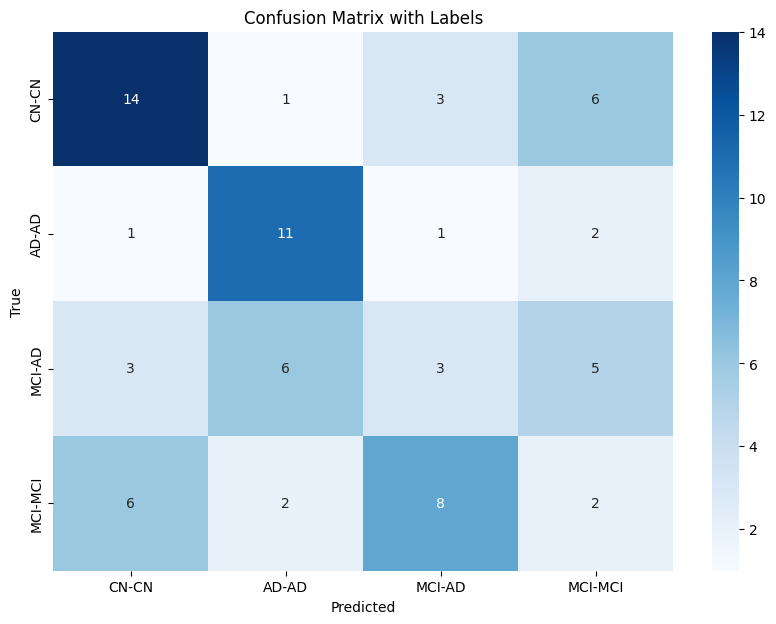

In [96]:

rf_model = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=34)


model_cross_score['random_forest'] = cross_val_score(rf_model, X_res, y_res, cv=5).mean()

rf_model.fit(X_res, y_res)


rf_pred = rf_model.predict(X_test)
print(classification_report(y_test, rf_pred))
cm = confusion_matrix(y_test, rf_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)



#### Extra Trees Classifier

              precision    recall  f1-score   support

           0       0.58      0.62      0.60        24
           1       0.46      0.40      0.43        15
           2       0.20      0.24      0.22        17
           3       0.40      0.33      0.36        18

    accuracy                           0.42        74
   macro avg       0.41      0.40      0.40        74
weighted avg       0.42      0.42      0.42        74



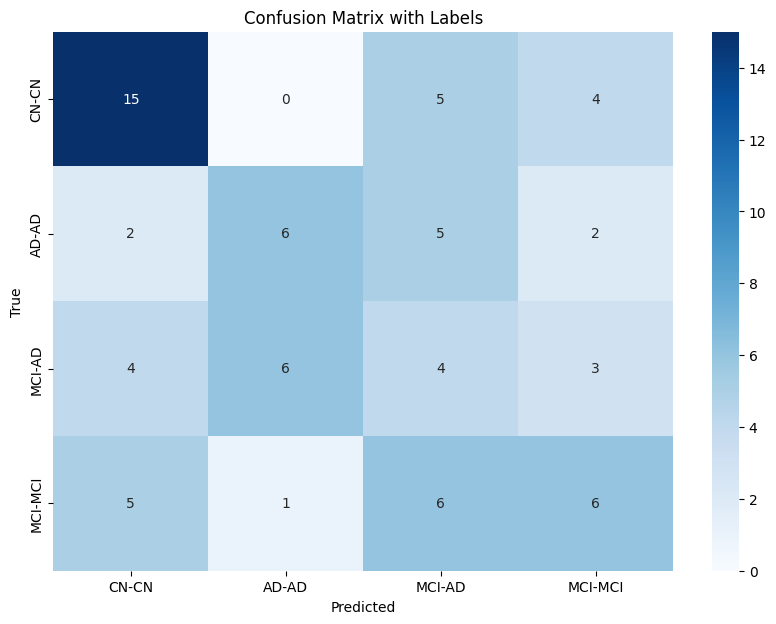

0.4189189189189189
0.6882032667876589


In [97]:
et_model = ExtraTreesClassifier(criterion='gini', max_depth=20, random_state=34)

model_cross_score['Extra Trees'] = cross_val_score(et_model, X_res, y_res, cv=5).mean()


et_model.fit(X_res, y_res)
et_pred = et_model.predict(X_test)
print(classification_report(y_test,et_pred))
cm = confusion_matrix(y_test,et_pred)
plot_confusion_matrix_with_labels(cm, label_mapping)
plt.show
print(accuracy_score(y_test, et_pred))
print(model_cross_score['Extra Trees'])

#### Gradient Boosting Classifier 

0.6919540229885057
              precision    recall  f1-score   support

           0       0.54      0.54      0.54        24
           1       0.50      0.47      0.48        15
           2       0.14      0.12      0.13        17
           3       0.23      0.28      0.25        18

    accuracy                           0.36        74
   macro avg       0.35      0.35      0.35        74
weighted avg       0.37      0.36      0.36        74



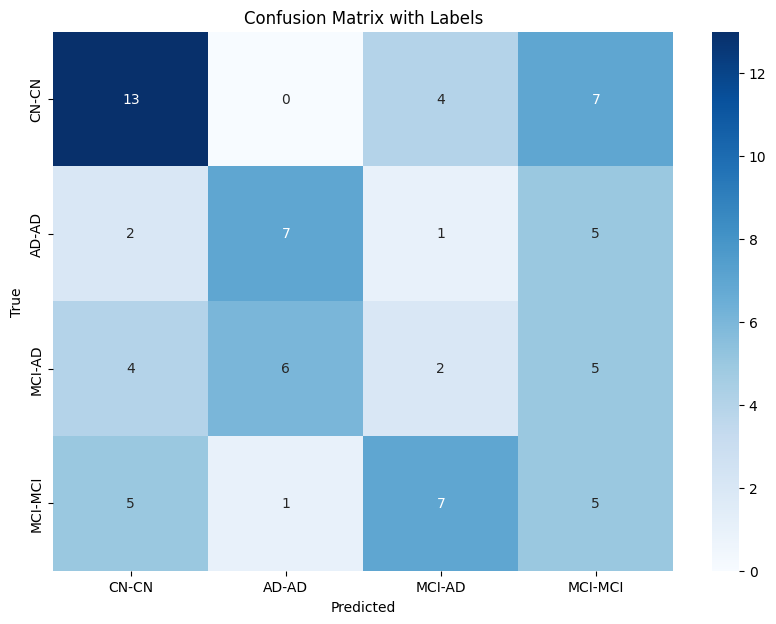

0.36486486486486486


In [98]:
gb_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=34)

score_cross = cross_val_score(gb_model,X_res,y_res,cv=5).mean()

print(score_cross)

model_cross_score['Gradient_boosting'] = score_cross


gb_model.fit(X_res, y_res)
gb_pred = gb_model.predict(X_test)
print(classification_report(y_test,gb_pred))
cm = confusion_matrix(y_test,gb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)
plt.show
print(accuracy_score(y_test, gb_pred))


#### K Neighbors Classifier

Acuracy k night 0.5362068965517242
              precision    recall  f1-score   support

           0       0.55      0.46      0.50        24
           1       0.43      0.67      0.53        15
           2       0.31      0.24      0.27        17
           3       0.22      0.22      0.22        18

    accuracy                           0.39        74
   macro avg       0.38      0.40      0.38        74
weighted avg       0.39      0.39      0.38        74



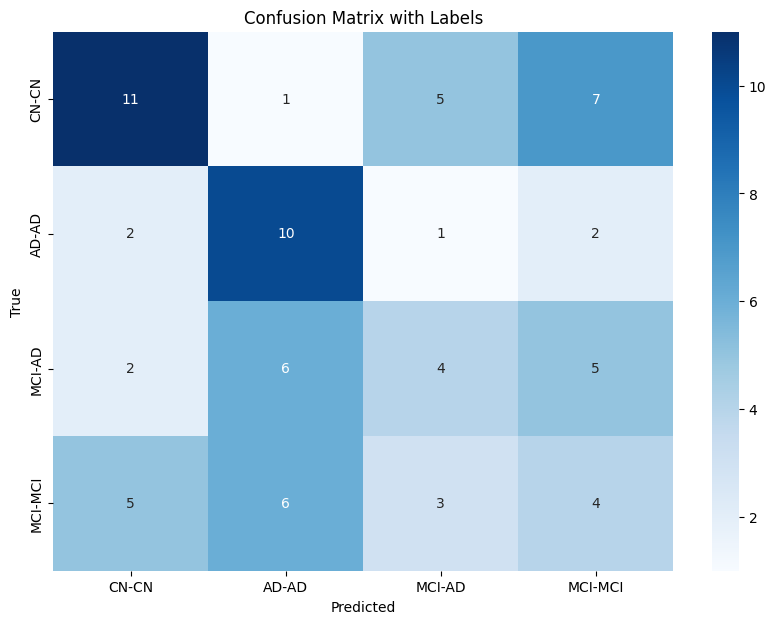

0.3918918918918919


In [99]:
kn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')

k_night_croos_score = cross_val_score(kn_model, X_res, y_res, cv=10)

print("Acuracy k night", k_night_croos_score.mean())


model_cross_score['k_night'] = k_night_croos_score.mean()

kn_model.fit(X_res, y_res)
kn_pred = kn_model.predict(X_test)
print(classification_report(y_test,kn_pred))
cm = confusion_matrix(y_test,kn_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)
plt.show
print(accuracy_score(y_test, kn_pred))


#### Extreme Gradient Boosting

0.6640653357531761
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        24
           1       0.54      0.47      0.50        15
           2       0.24      0.24      0.24        17
           3       0.27      0.22      0.24        18

    accuracy                           0.45        74
   macro avg       0.42      0.42      0.41        74
weighted avg       0.43      0.45      0.43        74



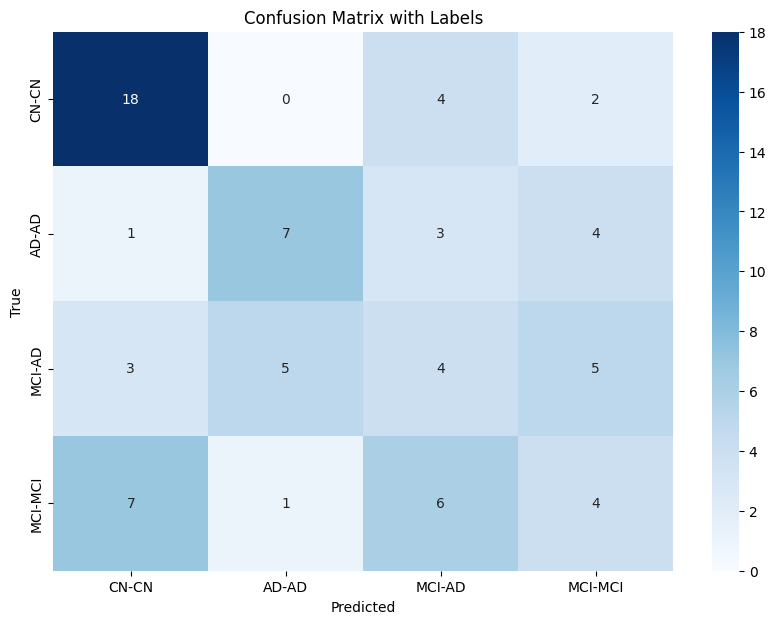

0.44594594594594594


In [100]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05,colsample_bytree=0.4, subsample=0.8, random_state=34)


score_cross = cross_val_score(xgb_model,X_res,y_res,cv=5).mean()

print(score_cross)

model_cross_score['XGBoost'] = score_cross


xgb_model.fit(X_res, y_res)
xgb_pred = xgb_model.predict(X_test)
print(classification_report(y_test,xgb_pred))
cm = confusion_matrix(y_test,xgb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)
plt.show
print(accuracy_score(y_test, xgb_pred))


SVC

0.6640653357531761
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        24
           1       0.54      0.47      0.50        15
           2       0.24      0.24      0.24        17
           3       0.27      0.22      0.24        18

    accuracy                           0.45        74
   macro avg       0.42      0.42      0.41        74
weighted avg       0.43      0.45      0.43        74



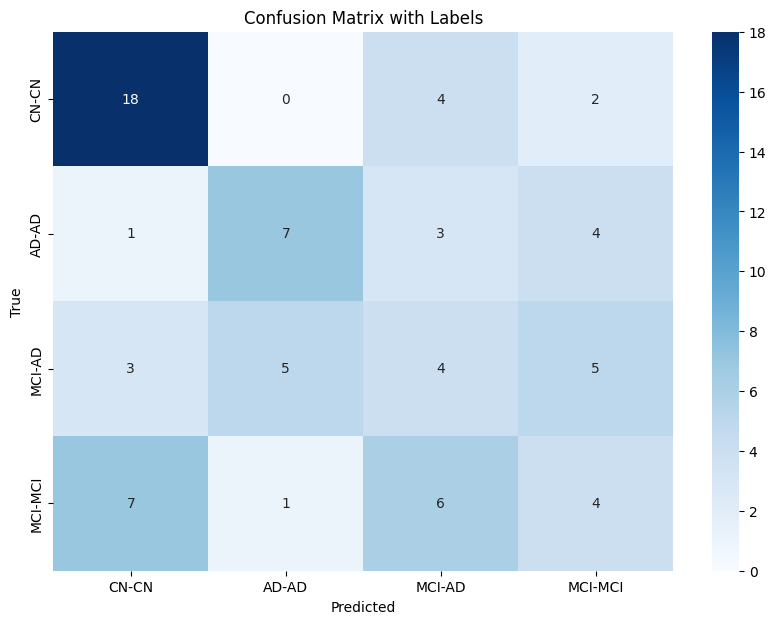

0.44594594594594594


In [101]:
from sklearn.svm import SVC


svc_moldel = SVC(kernel='rbf', random_state=34)


score_cross = cross_val_score(xgb_model,X_res,y_res,cv=5).mean()

print(score_cross)

model_cross_score['SVC'] = score_cross


svc_moldel.fit(X_res, y_res)
svc_pred = svc_moldel.predict(X_test)
print(classification_report(y_test,xgb_pred))
cm = confusion_matrix(y_test,xgb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)
plt.show
print(accuracy_score(y_test, xgb_pred))


In [102]:
print("Numero de Colunas")
print(X_train.shape)
print("Numero de Colunas com Smote")
print(X_res.shape)

# função que compara os modelos, para isso, usa um dicionário {"Model Name: [predictions], ..."}
def compare_models(Y_test, predictions):
    # Create a dictionary of models and their respective accuracies
    model_accuracies = {}
    for name, prediction in predictions.items():
        # Calculate the accuracy for each model
        accuracy = sum(prediction == Y_test) / len(Y_test)
        # Add the model and its accuracy to the dictionary
        model_accuracies[name] = accuracy

    # Sort the models by their accuracy in ascending order
    sorted_models = sorted(model_accuracies, key=model_accuracies.get)

    # Print the table with the accuracy of each model
    print("Model".ljust(20), "Accuracy")
    print("-" * 30)
    for model in sorted_models:
        print(model.ljust(20), str(model_accuracies[model]).rjust(10))


predictions = {
    'Random Forest Classifier' : rf_pred,
    'Extra Trees Classifier' : et_pred,
    'Gradient Boosting Classifier' : gb_pred,
    'K Neighbors Classifier' : kn_pred,
    'Extreme Gradient Boosting' : xgb_pred
    
}

compare_models(y_test, predictions)


def compare_models_cross_score(model_cross_score):
    # Sort models by cross-validation score in descending order
    sorted_models = sorted(model_cross_score.items(), key=lambda x: x[1], reverse=True)

    # Print the table with the cross-validation score of each model
    print("Model".ljust(30), "Cross-Validation Score")
    print("-" * 45)
    for model, score in sorted_models:
        print(model.ljust(30), f"{score:.4f}".rjust(10))



compare_models_cross_score(model_cross_score)


Numero de Colunas
(221, 2013)
Numero de Colunas com Smote
(288, 2013)
Model                Accuracy
------------------------------
Gradient Boosting Classifier 0.36486486486486486
K Neighbors Classifier 0.3918918918918919
Random Forest Classifier 0.40540540540540543
Extra Trees Classifier 0.4189189189189189
Extreme Gradient Boosting 0.44594594594594594
Model                          Cross-Validation Score
---------------------------------------------
Gradient_boosting                  0.6920
Extra Trees                        0.6882
XGBoost                            0.6641
SVC                                0.6641
random_forest                      0.6498
k_night                            0.5362


K means 

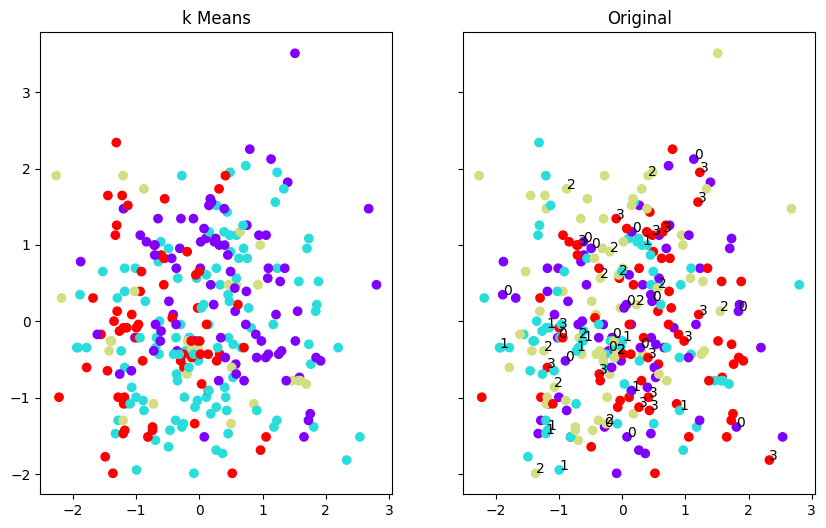

In [108]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=4,n_init='auto',random_state=34)
kmeans.fit(X_res)

f, (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize = (10,6))

ax1.set_title('k Means')
ax1.scatter(X_res[:,0], X_res[:,1], c = kmeans.labels_, cmap = 'rainbow')
ax2.set_title('Original')
ax2.scatter(X_res[:,0], X_res[:,1], c = y_res, cmap = 'rainbow')

for i, txt in enumerate(y_res): 
    if i%5==0: 
        plt.annotate(txt,(X_res[i,0], X_res[i,1]))



